# Importing packages and Libraries


In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import re
import spacy
from spacy.lang.en import English
from transformers import pipeline
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Loading models and pipelines

In [3]:
model = SentenceTransformer("all-MiniLM-L6-v2")
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

# EDA

In [4]:
df = pd.read_json('final_final.json')

In [5]:
df

,id,headline,text,image_id,anno_ids
0,0,AREA YOUTHS RATE HIGH AT FAIR,The 1969 edition of The Fayette County Fair is...,0,[4]
1,1,"‘Some excitement, but no big loss!’",Gary Manson seems to be all alone when a small...,0,[7]
2,2,"‘Life is wonderful, the second time around....!’","ARLINGTON (Special) - On\nSunday, August 24th ...",0,"[9, 10, 11]"
3,3,ARLINGTON HAS LOST\nA GOOD FRIEND,"Nettie Perkins, age 73 years\npassed away on W...",0,[13]
4,4,“We're all in our places....!”,"When Mrs, Sandy Quick opened the doors of her ...",0,[16]
...,...,...,...,...,...
112,112,Says Barracks\n‘Unnecessary’,-WASHINGTON @ — A house\nwatchdog committee. r...,9,[426]
113,113,4 Coal Miners\nKilled in Blast,"LANSFORD, Pa. (#—Four min-\ners were killed an...",9,[427]
114,114,"interim Pact:\nCovers 10,500\nin Pittsburgh Mu...",PITISBURGH — The CIO\nUnited Steelworkers hav...,9,[431]
115,115,Thought Man —\nWas Drowned |,"STEVENS POINT, Wis. —-A\nman thought to have d...",9,[433]


In [6]:
# Count rows with missing headline
missing_headline = df['headline'].eq('').sum()

# Count rows with missing text
missing_text = df['text'].eq('').sum()

# Print the results
print(f"Number of rows with missing headline: {missing_headline}")
print(f"Number of rows with missing text: {missing_text}")

Number of rows with missing headline: 0
Number of rows with missing text: 0


Maximum length of text articles: 788
Minimum length of text articles: 22
Average length of text articles: 239.76923076923077


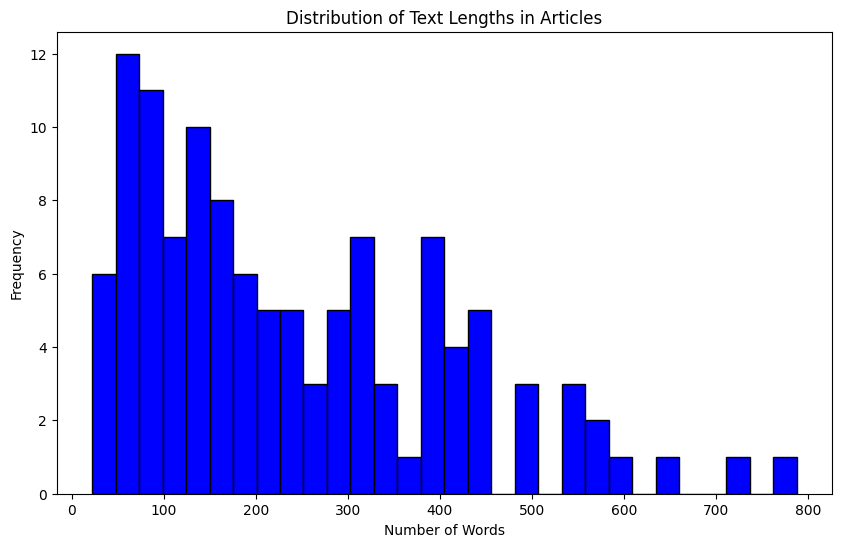

In [7]:
# Function to calculate the length of text in terms of number of words
def calculate_text_length(text):
    return len(text.split())

# Apply the function to the 'text' column and create a new 'text_length' column
df['text_length'] = df['text'].apply(calculate_text_length)

# Calculate the maximum, minimum, and average length of text articles
max_length = df['text_length'].max()
min_length = df['text_length'].min()
avg_length = df['text_length'].mean()

# Print the maximum, minimum, and average length of text articles
print("Maximum length of text articles:", max_length)
print("Minimum length of text articles:", min_length)
print("Average length of text articles:", avg_length)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, color='blue', edgecolor='black')
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths in Articles")
plt.show()

### Text Preprocessing

The `preprocess_text` function applies several text preprocessing techniques to clean and normalize the input text. The following preprocessing techniques are being used:

1. **Lowercase Conversion**: The text is converted to lowercase using `text.lower()`.
2. **Punctuation Removal**: All punctuation characters are removed from the text using the regular expression `re.sub(r'[^\w\s]', '', text)`.
3. **Number Removal**: All numeric digits are removed from the text using the regular expression `re.sub(r'\d+', '', text)`.
4. **Whitespace Normalization**: Multiple whitespaces, tabs, and newlines are replaced with a single space character using the regular expression `re.sub(r'\s+', ' ', text)`.
5. **Tokenization**: The text is tokenized into individual words using the SpaCy tokenizer.
6. **Lemmatization**: Each token is lemmatized (reduced to its base or dictionary form) using the SpaCy lemmatizer. This helps in normalizing different forms of the same word (e.g., "running" and "ran" are both reduced to "run").

After applying these preprocessing techniques, the lemmatized tokens are joined back into a single string, which represents the preprocessed text.

Further, we also apply stop word removal in `preprocess_text2`

In [2]:
def preprocess_text(text):
    # Load the English language model in SpaCy
    nlp = spacy.load("en_core_web_sm")

    # Create a SpaCy tokenizer
    tokenizer = English().tokenizer

    # Normalize the text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces, tabs, and newlines

    # Tokenize the text using SpaCy
    doc = nlp(text)
    # only Lemmatize
    lemmatized_tokens = [token.lemma_ for token in doc]
    # Join the lemmatized tokens back into a string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

In [9]:
def preprocess_text2(text):
    # Load the English language model in SpaCy
    nlp = spacy.load("en_core_web_sm")

    # Create a SpaCy tokenizer
    tokenizer = English().tokenizer

    # Normalize the text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces, tabs, and newlines

    # Tokenize the text using SpaCy
    doc = nlp(text)

    # Lemmatize and remove stop words
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]

    # Join the lemmatized tokens back into a string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

In [10]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [11]:
df['cleaned_text_nostopwords'] = df['text'].apply(preprocess_text2)

### Generating summary

In [12]:
# Function to generate summary for a given text
def generate_summary(text):
    summary = summarizer(text, max_length=100, min_length=30, truncation=True, do_sample=False)
    return summary[0]['summary_text']

# Apply the generate_summary function to the 'text' column and create a new 'summary' column with tqdm progress bar
tqdm.pandas()
df['summary'] = df['text'].progress_apply(generate_summary)

100%|██████████| 117/117 [27:29<00:00, 14.10s/it]


## Printing shape of embedding for columns: 'summary', 'headline', 'cleaned_text', 'cleaned_text_nostopwords', 'text'

In [13]:
def get_embeddings_shape(df, column_name):
    """
    Generate embeddings for the text in the specified column of the DataFrame
    and return the shape of the embeddings.

    Args:
    df (pd.DataFrame): The DataFrame containing the text data.
    column_name (str): The name of the column containing the text data.

    Returns:
    tuple: The shape of the embeddings matrix.
    """
    # Get the text data from the specified column
    articles = df[column_name].tolist()

    # Generate embeddings for the text data
    embeddings = model.encode(articles)

    # Print the shape of the embedding matrix
    print(f"The shape of the vector for column '{column_name}' is: {embeddings.shape}")

    return embeddings.shape

# Example usage
column_name = 'summary'
column_name1 = 'headline'
column_name2 = 'cleaned_text'
column_name3 = 'cleaned_text_nostopwords'
column_name4 = 'text'

embedding_shape = get_embeddings_shape(df, column_name)
embedding_shape = get_embeddings_shape(df, column_name1)
embedding_shape = get_embeddings_shape(df, column_name2)
embedding_shape = get_embeddings_shape(df, column_name3)
embedding_shape = get_embeddings_shape(df, column_name4)

The shape of the vector for column 'summary' is: (117, 384)
The shape of the vector for column 'headline' is: (117, 384)
The shape of the vector for column 'cleaned_text' is: (117, 384)
The shape of the vector for column 'cleaned_text_nostopwords' is: (117, 384)
The shape of the vector for column 'text' is: (117, 384)


### Similarity calculation of text with 'summary', 'headline', 'cleaned_text', 'cleaned_text_nostopwords' in order to know about semantic alignment

Average similarity between 'text' and 'summary': 0.7277275
Average similarity between 'text' and 'headline': 0.46785903
Average similarity between 'text' and 'cleaned_text': 0.8646999
Average similarity between 'text' and 'cleaned_text_nostopwords': 0.7410391


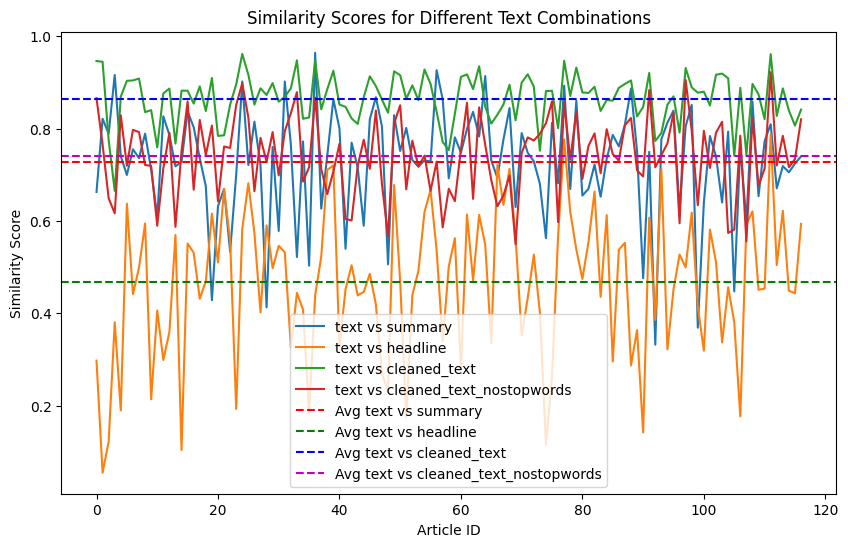

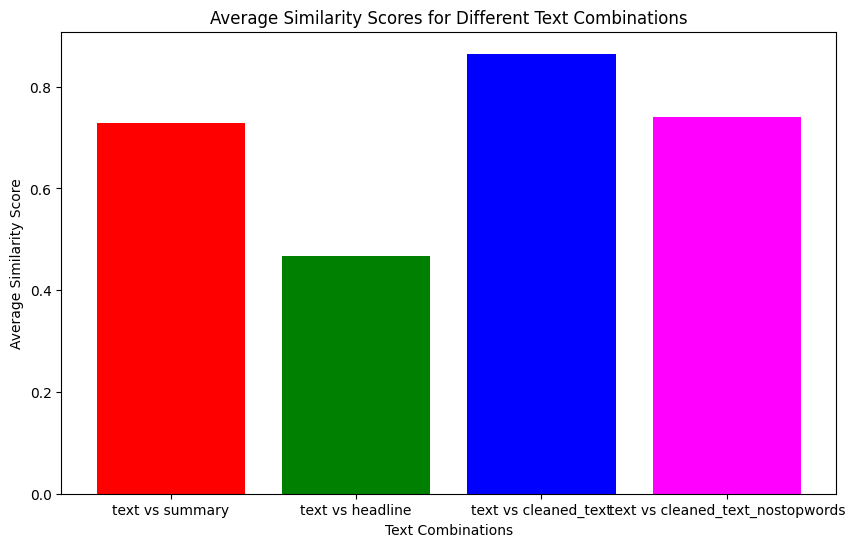

In [14]:
# Initialize lists to store similarity scores for each id
similarity_text_summary_list = []
similarity_text_headline_list = []
similarity_text_cleaned_list = []
similarity_text_nostopwords_list = []

# Column names to compare with 'text'
column_names = ['summary', 'headline', 'cleaned_text', 'cleaned_text_nostopwords']

# Iterate over each id from 0 to len(df)
for id in range(len(df)):
    # Get the text for each column at the current id
    text = df.loc[id, 'text']
    summary = df.loc[id, 'summary']
    headline = df.loc[id, 'headline']
    cleaned_text = df.loc[id, 'cleaned_text']
    cleaned_text_nostopwords = df.loc[id, 'cleaned_text_nostopwords']

    # Encode the sentences
    embeddings_text = model.encode([text])
    embeddings_summary = model.encode([summary])
    embeddings_headline = model.encode([headline])
    embeddings_cleaned_text = model.encode([cleaned_text])
    embeddings_cleaned_text_nostopwords = model.encode([cleaned_text_nostopwords])

    # Calculate the cosine similarity between the embeddings
    similarity_text_summary = cosine_similarity(embeddings_text, embeddings_summary)[0][0]
    similarity_text_headline = cosine_similarity(embeddings_text, embeddings_headline)[0][0]
    similarity_text_cleaned = cosine_similarity(embeddings_text, embeddings_cleaned_text)[0][0]
    similarity_text_nostopwords = cosine_similarity(embeddings_text, embeddings_cleaned_text_nostopwords)[0][0]

    # Append the similarity scores to the respective lists
    similarity_text_summary_list.append(similarity_text_summary)
    similarity_text_headline_list.append(similarity_text_headline)
    similarity_text_cleaned_list.append(similarity_text_cleaned)
    similarity_text_nostopwords_list.append(similarity_text_nostopwords)

# Calculate the average similarity scores
avg_similarity_text_summary = np.mean(similarity_text_summary_list)
avg_similarity_text_headline = np.mean(similarity_text_headline_list)
avg_similarity_text_cleaned = np.mean(similarity_text_cleaned_list)
avg_similarity_text_nostopwords = np.mean(similarity_text_nostopwords_list)

# Print the average similarity scores
print("Average similarity between 'text' and 'summary':", avg_similarity_text_summary)
print("Average similarity between 'text' and 'headline':", avg_similarity_text_headline)
print("Average similarity between 'text' and 'cleaned_text':", avg_similarity_text_cleaned)
print("Average similarity between 'text' and 'cleaned_text_nostopwords':", avg_similarity_text_nostopwords)

# Plot the continuous line graph
plt.figure(figsize=(10, 6))
plt.plot(similarity_text_summary_list, label="text vs summary")
plt.plot(similarity_text_headline_list, label="text vs headline")
plt.plot(similarity_text_cleaned_list, label="text vs cleaned_text")
plt.plot(similarity_text_nostopwords_list, label="text vs cleaned_text_nostopwords")
plt.axhline(y=avg_similarity_text_summary, color='r', linestyle='--', label="Avg text vs summary")
plt.axhline(y=avg_similarity_text_headline, color='g', linestyle='--', label="Avg text vs headline")
plt.axhline(y=avg_similarity_text_cleaned, color='b', linestyle='--', label="Avg text vs cleaned_text")
plt.axhline(y=avg_similarity_text_nostopwords, color='m', linestyle='--', label="Avg text vs cleaned_text_nostopwords")
plt.xlabel("Article ID")
plt.ylabel("Similarity Score")
plt.title("Similarity Scores for Different Text Combinations")
plt.legend()
plt.show()

# Plot the bar graph comparing the average similarity scores
avg_similarities = [avg_similarity_text_summary, avg_similarity_text_headline, avg_similarity_text_cleaned, avg_similarity_text_nostopwords]
labels = ['text vs summary', 'text vs headline', 'text vs cleaned_text', 'text vs cleaned_text_nostopwords']

plt.figure(figsize=(10, 6))
plt.bar(labels, avg_similarities, color=['red', 'green', 'blue', 'magenta'])
plt.xlabel("Text Combinations")
plt.ylabel("Average Similarity Score")
plt.title("Average Similarity Scores for Different Text Combinations")
plt.show()

In [15]:
def add_embedding_columns(df, columns):
    """
    Add embedding columns to the DataFrame for the specified text columns.

    Args:
    df (pd.DataFrame): The DataFrame containing the text data.
    columns (list): The list of column names to generate embeddings for.

    Returns:
    pd.DataFrame: The DataFrame with new embedding columns added.
    """
    for column in columns:
        # Generate embeddings for the text data in the specified column
        embeddings = model.encode(df[column].tolist())

        # Create a new column name by appending '_embedding' to the original column name
        embedding_column_name = f"{column}_embedding"

        # Add the embeddings as a new column in the DataFrame
        df[embedding_column_name] = list(embeddings)

    return df

# Example usage
columns_to_embed = ['summary', 'headline', 'cleaned_text', 'cleaned_text_nostopwords', 'text']
df = add_embedding_columns(df, columns_to_embed)


In [16]:
df

,id,headline,text,image_id,anno_ids,text_length,cleaned_text,cleaned_text_nostopwords,summary,summary_embedding,headline_embedding,cleaned_text_embedding,cleaned_text_nostopwords_embedding,text_embedding
0,0,AREA YOUTHS RATE HIGH AT FAIR,The 1969 edition of The Fayette County Fair is...,0,[4],124,the edition of the fayette county fair be now ...,edition fayette county fair history wake excit...,1969 edition of Fayette County Fair is now hi...,"[-0.041200813, 0.024484955, 0.018671948, 0.030...","[0.056374297, -0.026744671, 0.051953923, -0.03...","[0.01527292, -0.021927308, 0.013887543, -0.026...","[-0.0029716957, -0.019429198, 0.012634465, 0.0...","[-0.0038253102, -0.026347052, 0.0015225715, -0..."
1,1,"‘Some excitement, but no big loss!’",Gary Manson seems to be all alone when a small...,0,[7],83,gary manson seem to be all alone when a small ...,gary manson small house farm burn ground tuesd...,Arlington Volunteer Fire Department volunteer...,"[-0.013375542, 0.09361902, 0.08134189, -0.0240...","[0.026412422, 0.09763664, 0.024295751, 0.00876...","[0.05042335, 0.029605042, 0.08672836, -0.05912...","[0.013338198, 0.027382137, 0.0970569, -0.05763...","[0.053561088, 0.04982709, 0.08628174, -0.04280..."
2,2,"‘Life is wonderful, the second time around....!’","ARLINGTON (Special) - On\nSunday, August 24th ...",0,"[9, 10, 11]",221,arlington special on sunday august th the rdbi...,arlington special sunday august th rdbir thday...,Mary Ann Fox celebrated her 103rd birthday wi...,"[0.014717196, -0.018573595, 0.0231706, 0.01656...","[-0.042072702, 0.023140764, 0.11109833, 0.0580...","[-0.011044513, -0.020708356, 0.0944445, 0.0134...","[0.01221676, -0.0044386336, 0.05419657, 0.0201...","[-0.034790527, -0.013213413, 0.08051009, 0.019..."
3,3,ARLINGTON HAS LOST\nA GOOD FRIEND,"Nettie Perkins, age 73 years\npassed away on W...",0,[13],77,nettie perkin age year pass away on wednesday ...,nettie perkin age year pass away wednesday eve...,"Nettie Perkins, age 73, passed away on Wednes...","[0.06268157, -0.0038993242, -0.003953778, 0.02...","[-0.028832702, 0.05030213, 0.12233307, -0.0115...","[0.0005689807, 0.031494148, 0.052640237, -0.01...","[-0.021608476, 0.048307627, 0.047404382, -0.01...","[0.04345972, -0.00757232, 0.025949156, 0.01000..."
4,4,“We're all in our places....!”,"When Mrs, Sandy Quick opened the doors of her ...",0,[16],102,when mrs sandy quick open the door of her kind...,mrs sandy quick open door kindergarten room mo...,When Sandy Quick opened the doors of her kind...,"[0.020968255, 0.017906345, 0.027566396, 0.0620...","[0.05178134, 0.003890732, 0.008462346, -0.0092...","[-0.029366737, 0.019733142, -0.009801285, -0.0...","[-0.022943616, 0.041055806, -0.014033781, 0.02...","[-0.026565038, 0.030701973, -0.023457503, 0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,Says Barracks\n‘Unnecessary’,-WASHINGTON @ — A house\nwatchdog committee. r...,9,[426],135,washington a house watchdog committee report t...,washington house watchdog committee report day...,"A $370,000 pro-agogue project at Truax Field,...","[0.030615523, 0.06632126, -0.018102469, 0.0188...","[0.05762483, 0.088933475, -0.017876772, 0.0216...","[-0.010060589, 0.016051048, 0.0046590474, 0.06...","[0.017678838, 0.019988682, -0.0018336702, 0.06...","[0.00048240853, -0.0032057597, 0.01177216, 0.0..."
113,113,4 Coal Miners\nKilled in Blast,"LANSFORD, Pa. (#—Four min-\ners were killed an...",9,[427],106,lansford pa four min er be kill and seven othe...,lansford pa min er kill seven injure ina blast...,Explosion caught workers be-ginning the night...,"[-0.03857023, 0.06110809, 0.024154576, 0.08263...","[0.048882734, 0.0910744, -0.060070787, -0.0285...","[0.019938996, 0.0557005, 0.111013964, -0.04361...","[-0.022028435, 0.032959588, 0.07761499, -0.022...","[0.007901118, 0.060046982, 0.08040164, -0.0278..."
114,114,"interim Pact:\nCovers 10,500\nin Pittsburgh Mu...",PITISBURGH — The CIO\nUnited Steelworkers hav...,9,[431],536,pitisburgh the cio united 

In [27]:
df.to_json('part2.json', orient='records', indent=2)

## Classical NLP Sentiment Analysis

In [18]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [19]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
df_sent = df.copy()

In [21]:
# Function to calculate polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to headlines and text
df_sent['Polarity_text'], df_sent['Subjectivity_text'] = zip(*df_sent['text'].apply(get_sentiment))
df_sent['Polarity_headline'], df_sent['Subjectivity_headline'] = zip(*df_sent['headline'].apply(get_sentiment))

In [22]:
df_sent[["id","headline","text", "image_id","anno_ids", "Polarity_text", "Subjectivity_text", "Polarity_headline","Subjectivity_headline"]]

,id,headline,text,image_id,anno_ids,Polarity_text,Subjectivity_text,Polarity_headline,Subjectivity_headline
0,0,AREA YOUTHS RATE HIGH AT FAIR,The 1969 edition of The Fayette County Fair is...,0,[4],0.290000,0.576667,0.43,0.72
1,1,"‘Some excitement, but no big loss!’",Gary Manson seems to be all alone when a small...,0,[7],0.010243,0.320486,0.00,0.10
2,2,"‘Life is wonderful, the second time around....!’","ARLINGTON (Special) - On\nSunday, August 24th ...",0,"[9, 10, 11]",0.491270,0.601587,0.50,0.50
3,3,ARLINGTON HAS LOST\nA GOOD FRIEND,"Nettie Perkins, age 73 years\npassed away on W...",0,[13],0.250000,0.305000,0.70,0.60
4,4,“We're all in our places....!”,"When Mrs, Sandy Quick opened the doors of her ...",0,[16],0.230729,0.450000,0.00,0.00
...,...,...,...,...,...,...,...,...,...
112,112,Says Barracks\n‘Unnecessary’,-WASHINGTON @ — A house\nwatchdog committee. r...,9,[426],-0.048750,0.570000,-0.40,0.90
113,113,4 Coal Miners\nKilled in Blast,"LANSFORD, Pa. (#—Four min-\ners were killed an...",9,[427],-0.007143,0.114286,-0.20,0.00
114,114,"interim Pact:\nCovers 10,500\nin Pittsburgh Mu...",PITISBURGH — The CIO\nUnited Steelworkers hav...,9,[431],0.033168,0.297798,0.00,0.30
115,115,Thought Man —\nWas Drowned |,"STEVENS POINT, Wis. —-A\nman thought to have d...",9,[433],-0.016667,0.248611,-0.10,0.10


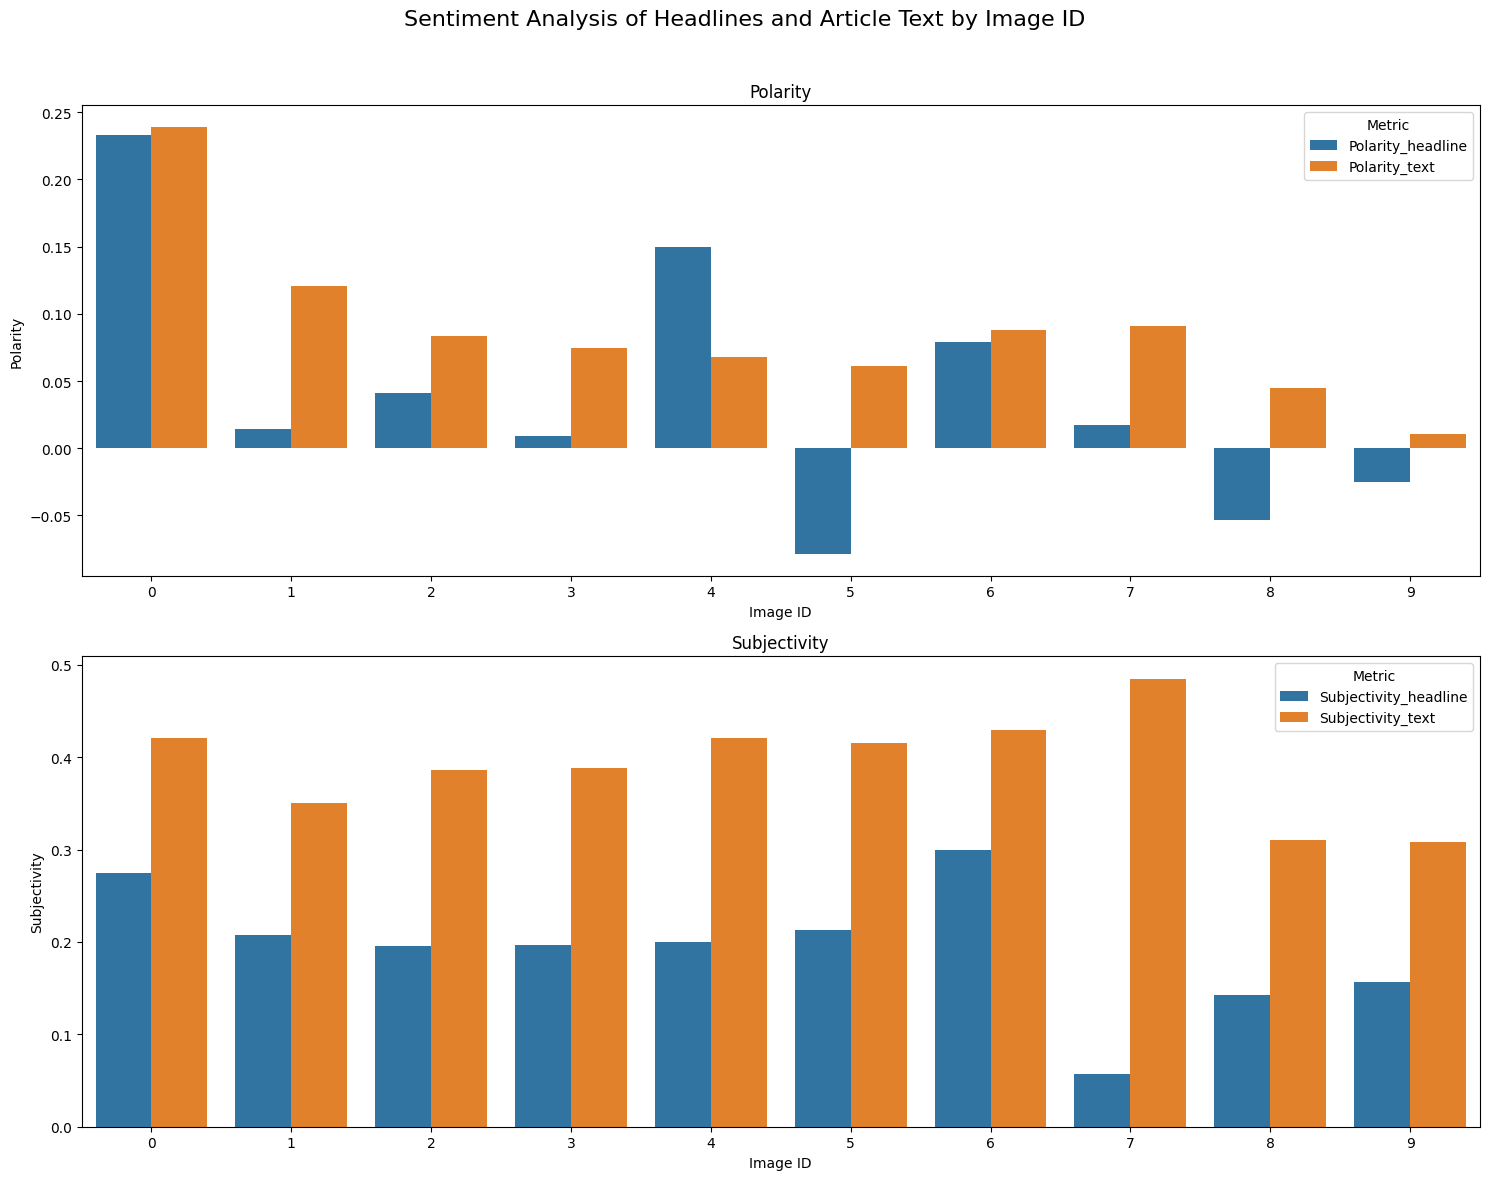

In [23]:
# Function to calculate polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to headlines and text
df_sent['Polarity_text'], df_sent['Subjectivity_text'] = zip(*df_sent['text'].apply(get_sentiment))
df_sent['Polarity_headline'], df_sent['Subjectivity_headline'] = zip(*df_sent['headline'].apply(get_sentiment))

# Select only the relevant columns for calculating the mean
columns_to_mean = ['image_id', 'Polarity_headline', 'Polarity_text', 'Subjectivity_headline', 'Subjectivity_text']
grouped_df = df_sent[columns_to_mean].groupby('image_id').mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(grouped_df, id_vars=['image_id'], value_vars=['Polarity_headline', 'Polarity_text', 'Subjectivity_headline', 'Subjectivity_text'],
                    var_name='Metric', value_name='Value')

# Separate polarity and subjectivity for plotting
polarity_df = melted_df[melted_df['Metric'].str.contains('Polarity')]
subjectivity_df = melted_df[melted_df['Metric'].str.contains('Subjectivity')]

# Plotting the bar plots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Sentiment Analysis of Headlines and Article Text by Image ID', fontsize=16)

# Plot for polarity
sns.barplot(x='image_id', y='Value', hue='Metric', data=polarity_df, ax=axes[0])
axes[0].set_title('Polarity')
axes[0].set_xlabel('Image ID')
axes[0].set_ylabel('Polarity')
axes[0].legend(title='Metric')

# Plot for subjectivity
sns.barplot(x='image_id', y='Value', hue='Metric', data=subjectivity_df, ax=axes[1])
axes[1].set_title('Subjectivity')
axes[1].set_xlabel('Image ID')
axes[1].set_ylabel('Subjectivity')
axes[1].legend(title='Metric')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [24]:
columns_to_mean = ['Polarity_text', 'Subjectivity_text', 'Polarity_headline', 'Subjectivity_headline']
mean_values = df_sent[columns_to_mean].mean()

# Print the mean values
print("Mean Values:")
print(mean_values)

Mean Values:
Polarity_text            0.072353
Subjectivity_text        0.366556
Polarity_headline        0.014809
Subjectivity_headline    0.179834
dtype: float64


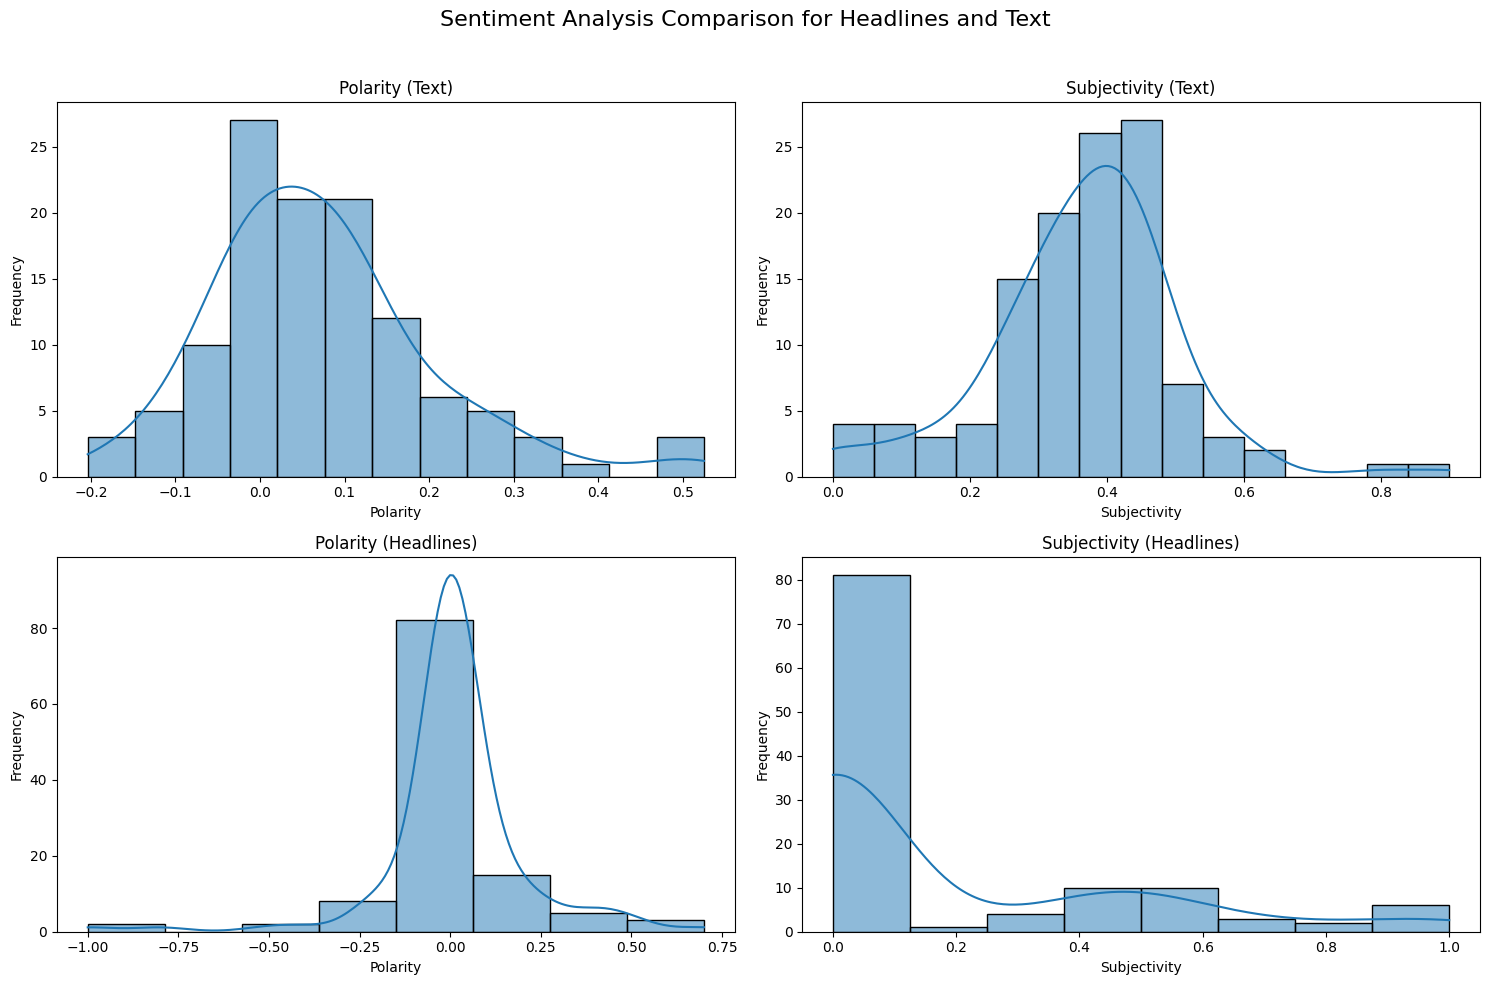

In [25]:
# Create a DataFrame for TextBlob sentiment analysis
df_textblob = df_sent[['Polarity_text', 'Subjectivity_text', 'Polarity_headline', 'Subjectivity_headline']]

# Plotting the sentiment analysis results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Analysis Comparison for Headlines and Text', fontsize=16)

# Polarity for Text
sns.histplot(df_textblob['Polarity_text'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Polarity (Text)')
axes[0, 0].set_xlabel('Polarity')
axes[0, 0].set_ylabel('Frequency')

# Subjectivity for Text
sns.histplot(df_textblob['Subjectivity_text'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Subjectivity (Text)')
axes[0, 1].set_xlabel('Subjectivity')
axes[0, 1].set_ylabel('Frequency')

# Polarity for Headlines
sns.histplot(df_textblob['Polarity_headline'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Polarity (Headlines)')
axes[1, 0].set_xlabel('Polarity')
axes[1, 0].set_ylabel('Frequency')

# Subjectivity for Headlines
sns.histplot(df_textblob['Subjectivity_headline'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Subjectivity (Headlines)')
axes[1, 1].set_xlabel('Subjectivity')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

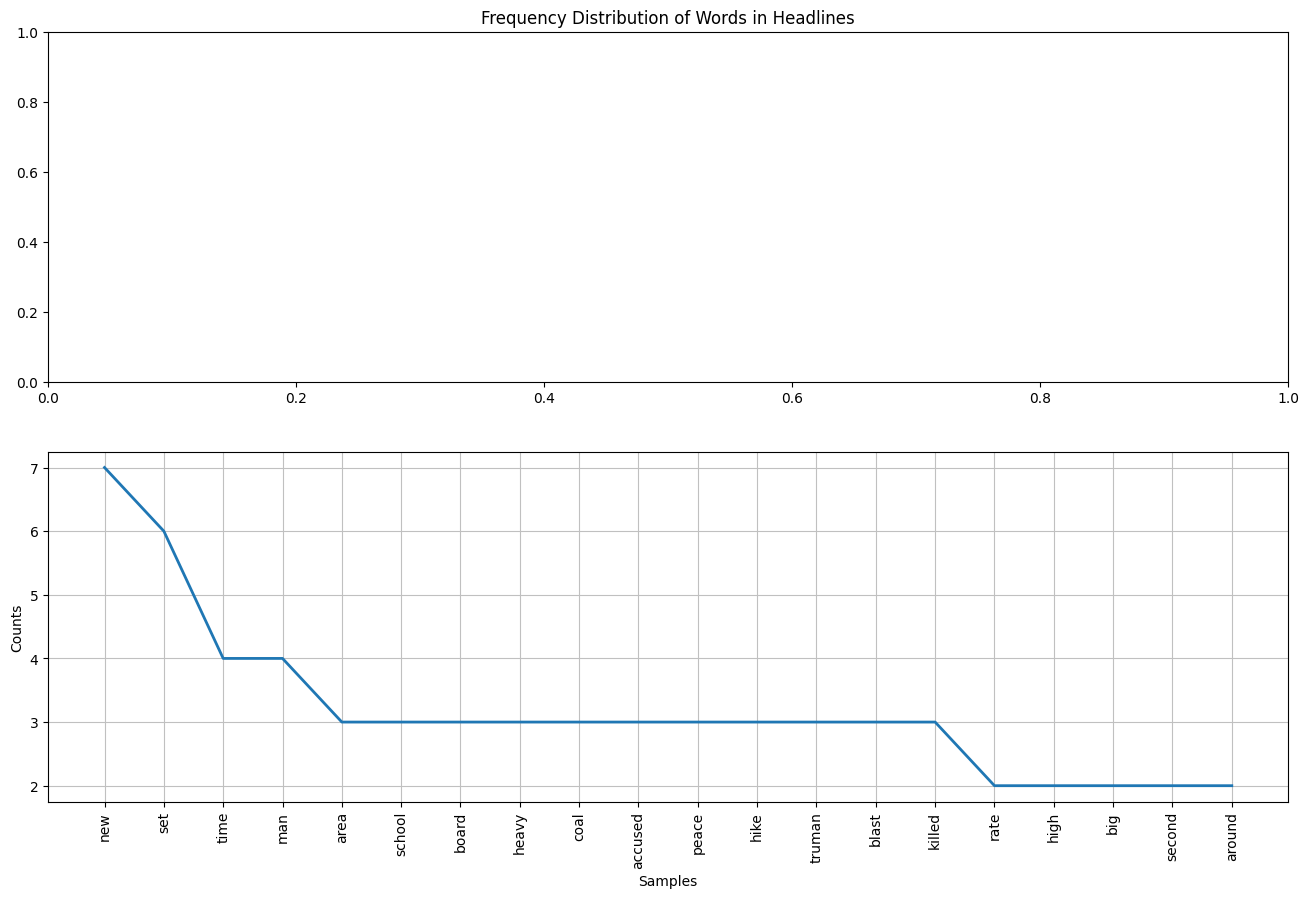

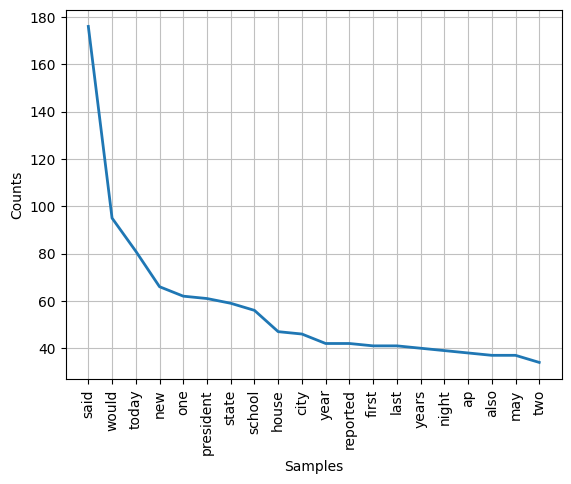

<Axes: xlabel='Samples', ylabel='Counts'>

In [39]:
# Function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words_filtered = [word for word in words if word.isalnum() and word not in stop_words]
    return words_filtered

# Preprocess headlines and text
df_sent['headline_words'] = df_sent['headline'].apply(preprocess_text)
df_sent['text_words'] = df['text'].apply(preprocess_text)

# Flatten the lists of words for headlines and text
all_headline_words = [word for words in df_sent['headline_words'] for word in words]
all_text_words = [word for words in df_sent['text_words'] for word in words]

# Calculate frequency distribution
headline_freq_dist = nltk.FreqDist(all_headline_words)
text_freq_dist = nltk.FreqDist(all_text_words)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot for headlines
axes[0].set_title('Frequency Distribution of Words in Headlines')
# plt.sca(axes[0])  # Set the current axes to axes[0]
headline_freq_dist.plot(20)

# Plot for text
axes[1].set_title('Frequency Distribution of Words in Text')
# plt.sca(axes[1])  # Set the current axes to axes[1]
text_freq_dist.plot(20)

# plt.tight_layout()
# plt.show()

In [29]:
# Combine text for each image_id
grouped_text = df_sent.groupby('image_id')['text'].apply(lambda x: ' '.join(x)).reset_index()

# Combine all text for the overall word cloud
overall_text = ' '.join(df_sent['text'])

In [30]:
# Function to generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(
        background_color='black',
        max_words=100,
        width=1400,
        height=1200
    ).generate(text)
    return wordcloud

# Generate word clouds for each image_id
grouped_text['wordcloud'] = grouped_text['text'].apply(generate_wordcloud)

# Generate word cloud for overall text
overall_wordcloud = generate_wordcloud(overall_text)

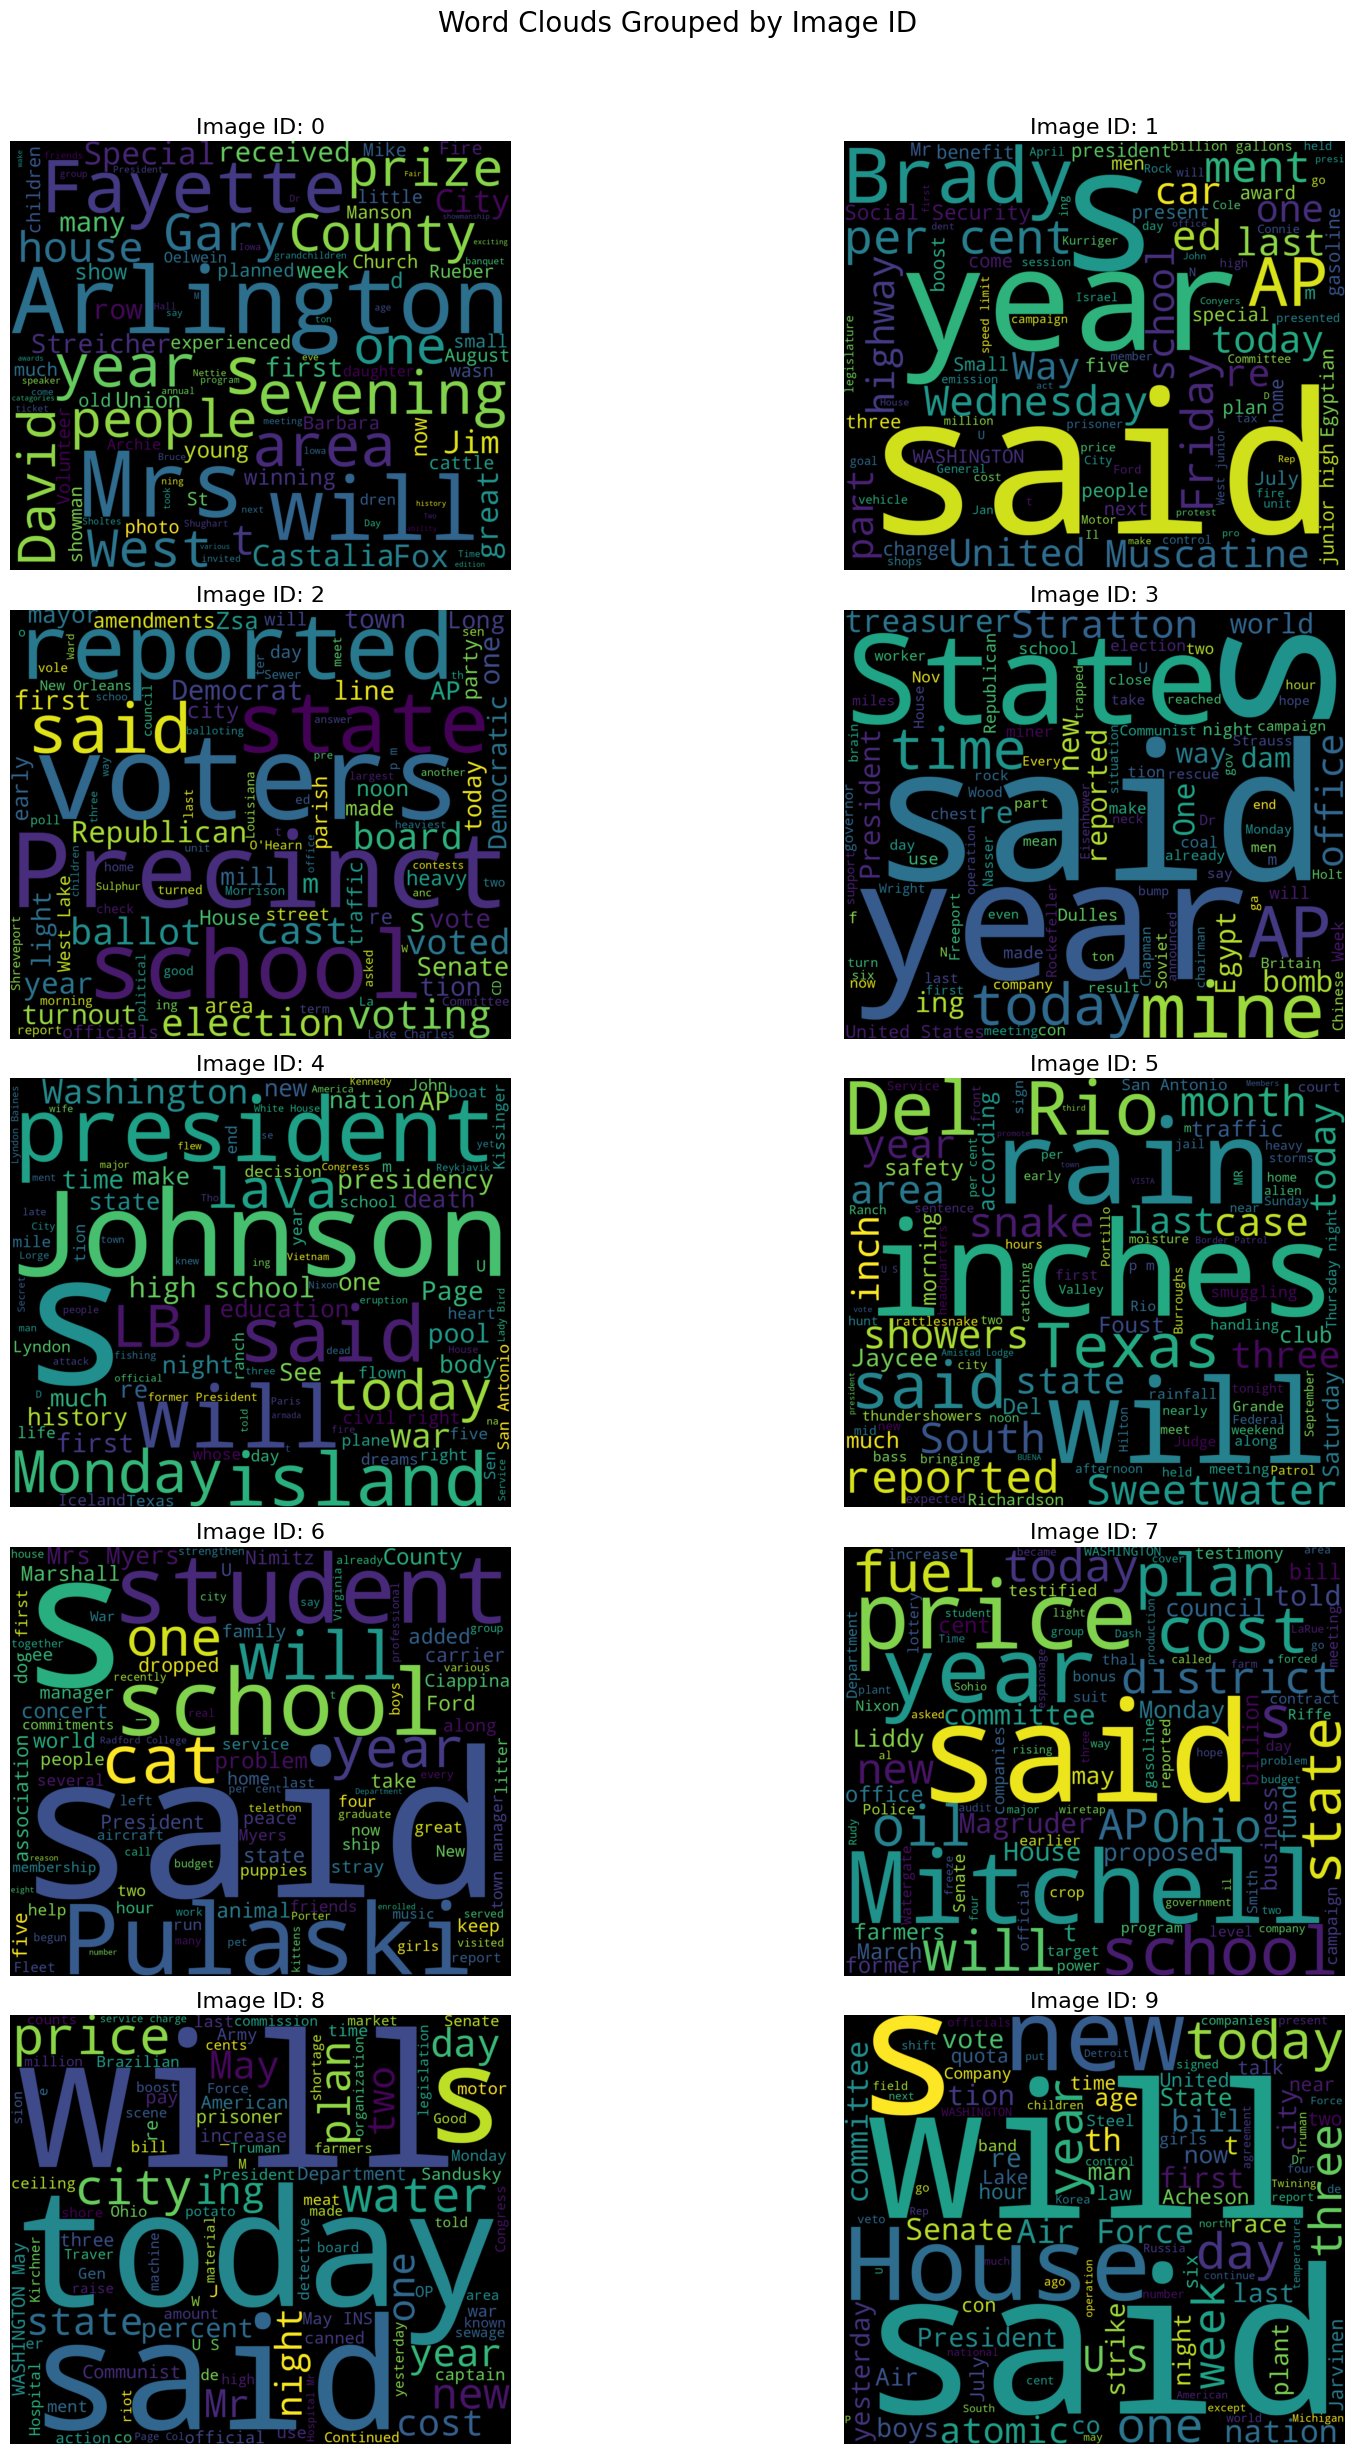

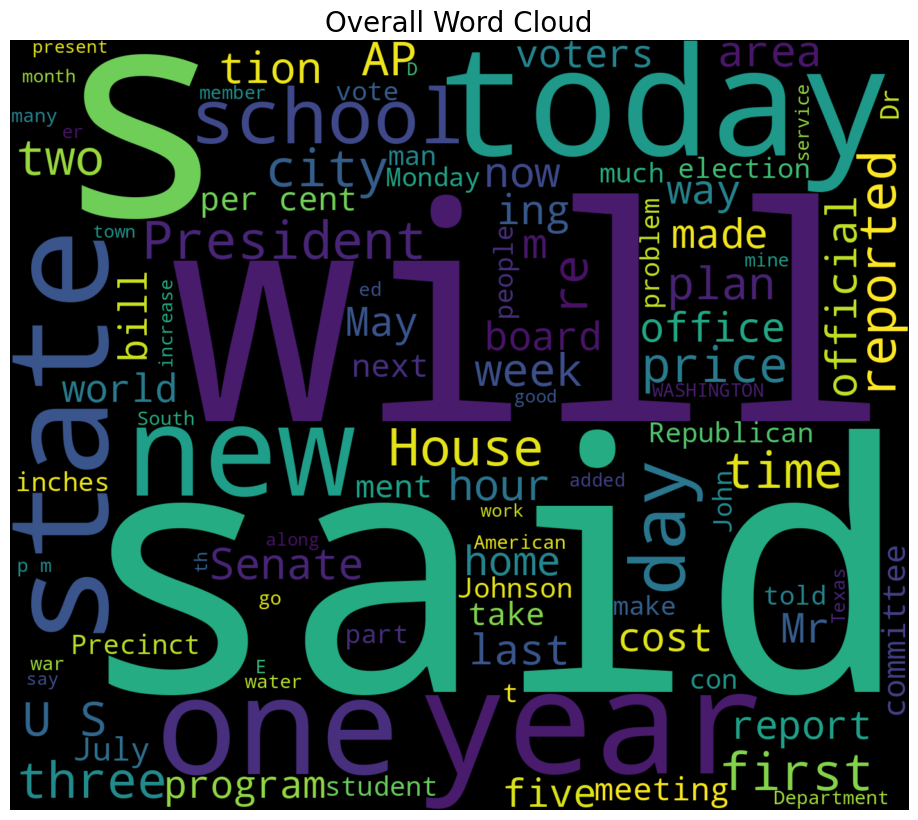

In [31]:
# Plotting the word clouds
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
fig.suptitle('Word Clouds Grouped by Image ID', fontsize=20)

# Plot word clouds for each image_id
for i, (image_id, wordcloud) in enumerate(zip(grouped_text['image_id'], grouped_text['wordcloud'])):
    ax = axes[i // 2, i % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Image ID: {image_id}', fontsize=16)
    ax.axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

# Plot the overall word cloud
plt.figure(figsize=(16, 10))
plt.imshow(overall_wordcloud, interpolation='bilinear')
plt.title('Overall Word Cloud', fontsize=20)
plt.axis('off')
plt.show()